In [1]:
import pandas as pd
import matplotlib.pyplot as plt


alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

with open("C:\\Users\\Samantha White\\Downloads\\sgb-words.txt", 'r') as file:
    raw_list = file.readlines()

    words = []
for i in raw_list:
    words.append(i[:5])


In [6]:
#maintenence code
def create_scoring_df(words, alphabet, columns=['1','2','3','4','5']):
    letter_dict = create_letter_dict(words, alphabet)
    word_position_df = create_word_position_df(words, columns)
    
    vc_dict_1 = create_value_counts_dict(word_position_df['1'])
    vc_dict_2 = create_value_counts_dict(word_position_df['2'])
    vc_dict_3 = create_value_counts_dict(word_position_df['3'])
    vc_dict_4 = create_value_counts_dict(word_position_df['4'])
    vc_dict_5 = create_value_counts_dict(word_position_df['5'])
    
    scoring_df = pd.DataFrame()
    scoring_df['word'] = words
    scoring_df['fixed_score'] = scoring_df['word'].apply(lambda x: scoring_with_position(x, vc_dict_1, vc_dict_2, vc_dict_3, vc_dict_4, vc_dict_5))
    scoring_df['flex_score'] = scoring_df['word'].apply(lambda x: scoring_no_position(x, letter_dict))
    scoring_df['total_score'] = scoring_df['fixed_score'] + scoring_df['flex_score']
    scoring_df = scoring_df.sort_values(by='total_score', ascending=False)
    
    return scoring_df

def plot_scoring_df(scoring_df):
    plt.figure(figsize=(15, 10))
    scoring_df.plot(kind='scatter',x='flex_score',y='fixed_score')
    plt.grid(True)  # Add gridlines for better readability
    plt.show()
    
def create_high_scores_df(scoring_df, fixed_score_threshold=4500, flex_score_threshold=11000):
    high_scores = scoring_df[(scoring_df['fixed_score']>=fixed_score_threshold) & (scoring_df['flex_score']>=flex_score_threshold)]
    return high_scores
        

def create_letter_dict(words, alphabet):
    letter_dict = {key: 0 for key in alphabet}
    for i in words:
        for c in i:
            letter_dict[c] = letter_dict[c]+1
    return letter_dict
            
def create_word_position_df(words, columns=['1','2','3','4','5']):
    data = []
    for w in words:
        data.append([char for char in w])
    df = pd.DataFrame(data, columns=columns)
    return df

def create_value_counts_dict(column):
    value_counts = {}
    for item in column:
        if item in value_counts:
            value_counts[item] += 1
        else:
            value_counts[item] = 1
    return value_counts

def create_word_score_dict_position(words, dict_1, dict_2, dict_3, dict_4, dict_5):
    word_score_dict = {}
    for w in words:
        word_score = scoring_with_position(w, vc_dict_1, vc_dict_2, vc_dict_3, vc_dict_4, vc_dict_5)
        word_score_dict[w] = word_score
    word_score_dict = dict(sorted(word_score_dict.items(), key=lambda item: item[1], reverse=True))
    return word_score_dict

def create_word_score_dict_no_position(words, letter_dict):
    word_score_dict= {}
    for w in words:
        word_score = scoring_no_position(w, letter_dict)
        word_score_dict[w] = word_score
    word_score_dict = dict(sorted(word_score_dict.items(), key=lambda item: item[1], reverse=True))
    return word_score_dict


#scoring code

def scoring_with_position(word, dict_1, dict_2, dict_3, dict_4, dict_5):
    word_score = 0
    char_list = [char for char in word]  
    word_score = word_score + dict_1[char_list[0]] + dict_2[char_list[1]] + dict_3[char_list[2]] + dict_4[char_list[3]] + dict_5[char_list[4]]
    return word_score

def scoring_no_position(word, letter_dict):
    word_score = 0
    char_list = [char for char in word]
    unique_characters = set(char_list)
    for i in unique_characters:
        word_score = word_score + letter_dict[i]
    return word_score


#guessing
def guess(guessed_word, words, colors, alphabet=alphabet):
    filtered_words_1 = filter_words_list_after_guess(guessed_word, words, colors[0])
    filtered_words_2 = filter_words_list_after_guess(guessed_word, words, colors[1])
    filtered_words_3 = filter_words_list_after_guess(guessed_word, words, colors[2])
    filtered_words_4 = filter_words_list_after_guess(guessed_word, words, colors[3])
    
    scoring_df_1 = create_scoring_df(filtered_words_1, alphabet)
    scoring_df_2 = create_scoring_df(filtered_words_2, alphabet)
    scoring_df_3 = create_scoring_df(filtered_words_3, alphabet)
    scoring_df_4 = create_scoring_df(filtered_words_4, alphabet)
    
    scoring_df = scoring_df_1.copy()
    scoring_df = scoring_df.append(scoring_df_2).append(scoring_df_3).append(scoring_df_4)
    scoring_df = scoring_df.drop_duplicates()
    
    filtered_words_list = list(scoring_df['word'])
    
    return scoring_df, filtered_words_list


def filter_words_list_after_guess(guessed_word, words, colors):
    results_df = create_results_df(guessed_word, colors)
    
    grey_letters = []
    remove_letters = []
    wrong_placement = {}
    wrong_placement_list = []
    correct_placement = {}
    correct_placement_list = []
    
    for index, row in results_df.iterrows():
        if row['color'] == 'grey':
            grey_letters.append(row['letter'])
        elif row['color'] == 'yellow':
            wrong_placement[row['letter']] = row['position']
            wrong_placement_list.append(row['letter'])
        elif row['color'] == 'green':
            correct_placement[row['letter']] = row['position']
            correct_placement_list.append(row['letter'])
            
    for i in grey_letters:
        filtered_df = results_df[results_df['letter']==i]
        colors = list(filtered_df['color'])
        if ('yellow' not in colors) and ('green' not in colors):
            remove_letters.append(i)
            
    new_words_list = []
    removed_words = []
    
    for w in words:
        for l in remove_letters:
            if (l in w) and (w not in removed_words):
                removed_words.append(w)      
    
    for i in wrong_placement:
        for w in words:
            word = [char for char in w]
            if (word[wrong_placement[i]] == i) and (w not in removed_words):
                removed_words.append(w)
                                
    for w in words:
        if w not in removed_words:
            new_words_list.append(w)
            
    new_new_words_list = []
    
    for i in new_words_list:
        if len(wrong_placement_list) == 0:
            new_new_words_list = new_words_list.copy()
        elif len(wrong_placement_list) == 1:
            if wrong_placement_list[0] in i:
                new_new_words_list.append(i)
        elif len(wrong_placement_list) == 2:
            if (wrong_placement_list[0] in i) and (wrong_placement_list[1] in i):
                new_new_words_list.append(i)
        elif len(wrong_placement_list) == 3:
            if (wrong_placement_list[0] in i) and (wrong_placement_list[1] in i) and (wrong_placement_list[2] in i):
                new_new_words_list.append(i)
        elif len(wrong_placement_list) == 4:
            if (wrong_placement_list[0] in i) and (wrong_placement_list[1] in i) and (wrong_placement_list[2] in i) and (wrong_placement_list[3] in i):
                new_new_words_list.append(i)
        elif len(wrong_placement_list) == 5:
            if (wrong_placement_list[0] in i) and (wrong_placement_list[1] in i) and (wrong_placement_list[2] in i) and (wrong_placement_list[3] in i) and (wrong_placement_list[4] in i):
                new_new_words_list.append(i)
    
    new_new_new_words_list = []
    
    for i in new_new_words_list:
        word = [char for char in i]
        if len(correct_placement_list) == 0:
            new_new_new_words_list = new_new_words_list.copy()
            
        elif len(correct_placement_list) == 1:
            letter_1 = correct_placement_list[0]
            position_1 = correct_placement[letter_1]
            if word[position_1] == letter_1:
                new_new_new_words_list.append(i)
            
        elif len(correct_placement_list) == 2:
            letter_1 = correct_placement_list[0]
            position_1 = correct_placement[letter_1]
            letter_2 = correct_placement_list[1]
            position_2 = correct_placement[letter_2]
            if (word[position_1] == letter_1) and (word[position_2] == letter_2):
                new_new_new_words_list.append(i)
            
        elif len(correct_placement_list) == 3:
            letter_1 = correct_placement_list[0]
            position_1 = correct_placement[letter_1]
            letter_2 = correct_placement_list[1]
            position_2 = correct_placement[letter_2]
            letter_3 = correct_placement_list[2]
            position_3 = correct_placement[letter_3]
            if (word[position_1] == letter_1) and (word[position_2] == letter_2) and (word[position_3] == letter_3):
                new_new_new_words_list.append(i)
            
        elif len(correct_placement_list) == 4:
            letter_1 = correct_placement_list[0]
            position_1 = correct_placement[letter_1]
            letter_2 = correct_placement_list[1]
            position_2 = correct_placement[letter_2]
            letter_3 = correct_placement_list[2]
            position_3 = correct_placement[letter_3]
            letter_4 = correct_placement_list[3]
            position_4 = correct_placement[letter_4]
            if (word[position_1] == letter_1) and (word[position_2] == letter_2) and (word[position_3] == letter_3) and (word[position_4] == letter_4):
                new_new_new_words_list.append(i)
    
    return new_new_new_words_list


def create_results_df(guessed_word, colors):
    results_df = pd.DataFrame()
    results_df['letter'] = [char for char in guessed_word]
    results_df['position'] = [0, 1, 2, 3, 4]
    results_df['color'] = colors
    return results_df


In [3]:
scoring_df = create_scoring_df(words, alphabet)
high_scores_df = create_high_scores_df(scoring_df)
high_scores_df

,word,fixed_score,flex_score,total_score
3578,tares,4773,11885,16658
633,tales,4686,11561,16247
2021,dares,4708,11481,16189
3079,lores,4649,11453,16102
1220,cares,4837,11264,16101
5717,nares,4515,11585,16100
3153,pares,4783,11255,16038
1172,roles,4559,11453,16012
1421,lanes,4603,11261,15864
2854,bares,4829,11015,15844


<Figure size 1080x720 with 0 Axes>

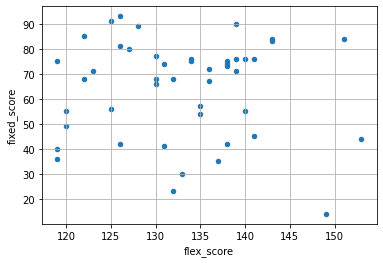

In [5]:
plot_scoring_df(scoring_df_1)

In [6]:
create_high_scores_df(scoring_df_1, fixed_score_threshold=80, flex_score_threshold=150)

,word,fixed_score,flex_score
40,tench,84,151


In [7]:
#guess 1
word_guessed = 'tales'
colors_1 = ['grey', 'grey', 'yellow', 'grey', 'grey']
colors_2 = ['grey', 'grey', 'grey', 'yellow', 'yellow']
colors_3 = ['grey', 'grey', 'grey', 'grey', 'grey']
colors_4 = ['grey', 'yellow', 'yellow', 'grey', 'grey']

scoring_df_1, filtered_words_1 = guess(word_guessed, words, [colors_1, colors_2, colors_3, colors_4])
scoring_df_1

,word,fixed_score,flex_score,total_score
79,doily,134,342,476
120,roily,128,345,473
15,glory,137,308,445
9,cloud,125,310,435
104,drily,123,311,434
...,...,...,...,...
53,amply,49,248,297
85,luvya,44,250,294
6,apply,49,236,285
68,phyla,43,242,285


In [8]:
#guess 2
word_guessed = 'doily'
colors_1 = ['grey', 'grey', 'green', 'green', 'grey']
colors_2 = ['yellow', 'grey', 'grey', 'grey', 'green']
colors_3 = ['yellow', 'yellow', 'grey', 'grey', 'grey']
colors_4 = ['grey', 'grey', 'grey', 'yellow', 'grey']

scoring_df_2, filtered_words_2 = guess(word_guessed, filtered_words_1, [colors_1, colors_2, colors_3, colors_4])
scoring_df_2


,word,fixed_score,flex_score,total_score
0,grill,21,22,43
1,frill,21,22,43
2,chill,21,22,43
3,krill,21,22,43
4,quill,19,20,39
...,...,...,...,...
14,bluff,56,99,155
46,alpha,46,104,150
15,lunch,28,119,147
17,fluff,57,90,147


In [9]:
#guess 3
word_guessed = 'grill'
colors_1 = ['green', 'green', 'green', 'green', 'green']
colors_2 = ['grey', 'grey', 'grey', 'grey', 'grey']
colors_3 = ['grey', 'green', 'grey', 'grey', 'grey']
colors_4 = ['grey', 'yellow', 'grey', 'grey', 'green']

scoring_df_3, filtered_words_3 = guess(word_guessed, filtered_words_2, [colors_1, colors_2, colors_3, colors_4])
scoring_df_3

,word,fixed_score,flex_score,total_score
0,muddy,11.0,11.0,22.0
1,buddy,11.0,11.0,22.0
2,seedy,9.0,11.0,20.0
0,frond,14.0,15.0,29.0
1,proud,14.0,15.0,29.0
2,crowd,14.0,15.0,29.0
3,brood,14.0,14.0,28.0
0,mural,15.0,21.0,36.0
1,aural,15.0,20.0,35.0
3,rural,15.0,20.0,35.0


In [10]:
#guess 4
word_guessed = 'muddy'
colors_1 = ['green', 'green', 'green', 'green', 'green']
colors_2 = ['grey', 'grey', 'grey', 'green', 'green']
colors_3 = ['grey', 'grey', 'yellow', 'grey', 'grey']
colors_4 = ['green', 'green', 'grey', 'grey', 'grey']

scoring_df_4, filtered_words_4 = guess(word_guessed, filtered_words_3, [colors_1, colors_2, colors_3, colors_4])
scoring_df_4

,word,fixed_score,flex_score,total_score
0,seedy,5.0,5.0,10.0
0,frond,11.0,12.0,23.0
1,crowd,11.0,12.0,23.0
2,brood,11.0,11.0,22.0
0,mural,5.0,5.0,10.0


In [11]:
#guess 5
word_guessed = 'seedy'
colors_1 = ['green', 'green', 'green', 'green', 'green']
colors_2 = ['green', 'green', 'green', 'green', 'green']
colors_3 = ['grey', 'grey', 'grey', 'yellow', 'grey']
colors_4 = ['grey', 'grey', 'grey', 'grey', 'grey']

scoring_df_5, filtered_words_5 = guess(word_guessed, filtered_words_4, [colors_1, colors_2, colors_3, colors_4])
scoring_df_5

,word,fixed_score,flex_score,total_score
0,frond,11.0,12.0,23.0
1,crowd,11.0,12.0,23.0
2,brood,11.0,11.0,22.0
0,mural,5.0,5.0,10.0


In [12]:
#guess 6
word_guessed = 'crowd'
colors_1 = ['green', 'green', 'green', 'green', 'green']
colors_2 = ['green', 'green', 'green', 'green', 'green']
colors_3 = ['grey', 'green', 'green', 'grey', 'green']
colors_4 = ['grey', 'yellow', 'grey', 'grey', 'grey']

scoring_df_6, filtered_words_6 = guess(word_guessed, filtered_words_5, [colors_1, colors_2, colors_3, colors_4])
scoring_df_6

,word,fixed_score,flex_score,total_score
0,frond,8.0,9.0,17.0
1,brood,8.0,8.0,16.0
0,mural,5.0,5.0,10.0


In [13]:
#guess 7
word_guessed = 'frond'
colors_1 = ['green', 'green', 'green', 'green', 'green']
colors_2 = ['green', 'green', 'green', 'green', 'green']
colors_3 = ['green', 'green', 'green', 'green', 'green']
colors_4 = ['grey', 'yellow', 'grey', 'grey', 'grey']

scoring_df_7, filtered_words_7 = guess(word_guessed, filtered_words_6, [colors_1, colors_2, colors_3, colors_4])
scoring_df_7

,word,fixed_score,flex_score,total_score
0,mural,5.0,5.0,10.0
